# Experiment Summary Analysis

This notebook analyzes the experimental runs captured in **`experiment_summary.csv`**, covering the following topics:

- Main statistics about the experiment, computational requirements, number of epochs and average runtime per epoch.
- Reproducibility results for the benchmark datasets (AGNews, DBPedia, IMDb, Amazon).
- Ablation/Extension 1 Results: Learning Rate and Batch Size Impact on Model Performance.
- Ablation/Extension 2 Results: Increasing the Number of Labeling Functions for the DBPedia Dataset.
- Reproducibility results for the MIMIC-3 discharge notes dataset.

In [10]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import json
import datetime
import uuid
import numpy as np
import seaborn as sns

In [11]:
DATA_PATH = 'experiment_summary.csv'

# # Inline charts
# %matplotlib inline

In [12]:
df = pd.read_csv(DATA_PATH)
print(f"Loaded {len(df)} experiments from {DATA_PATH}")
df.head()

Loaded 139 experiments from experiment_summary.csv


,Dataset,Experiment ID,Log Filename,Status,Learning Rate,Batch Size,LFs,Label Model,N-Gram Range,Class Descriptions,...,EM Recall,EM Recall STD,EM Epochs,ST Accuracy/F1,ST Accuracy/F1 STD,ST Precision,ST Precision STD,ST Recall,ST Recall STD,ST Epochs
0,agnews,agnews_lr_1e-3_b_128_lf_300_dp_20250413_02-55-19,agnews_lr_1e-3_b_128_lf_300_dp_20250413_02-55-...,Finished,0.001,128.0,300.0,Data Programming,"(1, 3)",NaN,...,0.829167,0.004718,14.0,0.863889,0.003738,0.873218,0.003299,0.863889,0.003738,74.0
1,agnews,agnews_lr_1e-3_b_128_lf_300_mv_20250413_03-17-53,agnews_lr_1e-3_b_128_lf_300_mv_20250413_03-17-...,Finished,0.001,128.0,300.0,Majority Vote,"(1, 3)",NaN,...,0.831758,0.004104,9.0,0.845158,0.003809,0.844435,0.003929,0.845158,0.003809,17.0
2,agnews,agnews_lr_1e-3_b_128_lf_15_dp_20250411_16-03-59,agnews_lr_1e-3_b_128_lf_15_dp_20250411_16-03-5...,Finished,0.001,128.0,15.0,Data Programming,"(1, 3)",NaN,...,0.727838,0.005428,9.0,0.721361,0.004794,0.762730,0.006032,0.721361,0.004794,151.0
3,agnews,agnews_lr_1e-3_b_128_lf_15_mv_20250411_16-21-32,agnews_lr_1e-3_b_128_lf_15_mv_20250411_16-21-3...,Finished,0.001,128.0,15.0,Majority Vote,"(1, 3)",NaN,...,0.748359,0.005303,9.0,0.792507,0.004423,0.799070,0.004396,0.792507,0.004423,103.0
4,agnews,agnews_lr_1e-3_b_64_lf_300_dp_20250413_03-48-22,agnews_lr_1e-3_b_64_lf_300_dp_20250413_03-48-2...,Finished,0.001,64.0,300.0,Data Programming,"(1, 3)",NaN,...,0.827863,0.004248,19.0,0.867349,0.004324,0.867690,0.004342,0.867349,0.004324,61.0


# 1. Main Statistics

## 1.1 Experiment Breakdown by Dataset, Device and Completion Status

In [13]:
pivot = (df
         .groupby(['Dataset', 'Status'])
         .size()
         .unstack(fill_value=0)
         .sort_index())
pivot

Status,Failed (Out of Memory),Failed (Unknown Reason),Finished,Finished (w/o self-train),Interrupted by User
Dataset,,,,,
agnews,0,0,24,0,0
amazon,0,1,6,6,1
dbpedia,3,2,22,0,0
imdb,0,0,12,0,3
mimic,22,8,26,0,3


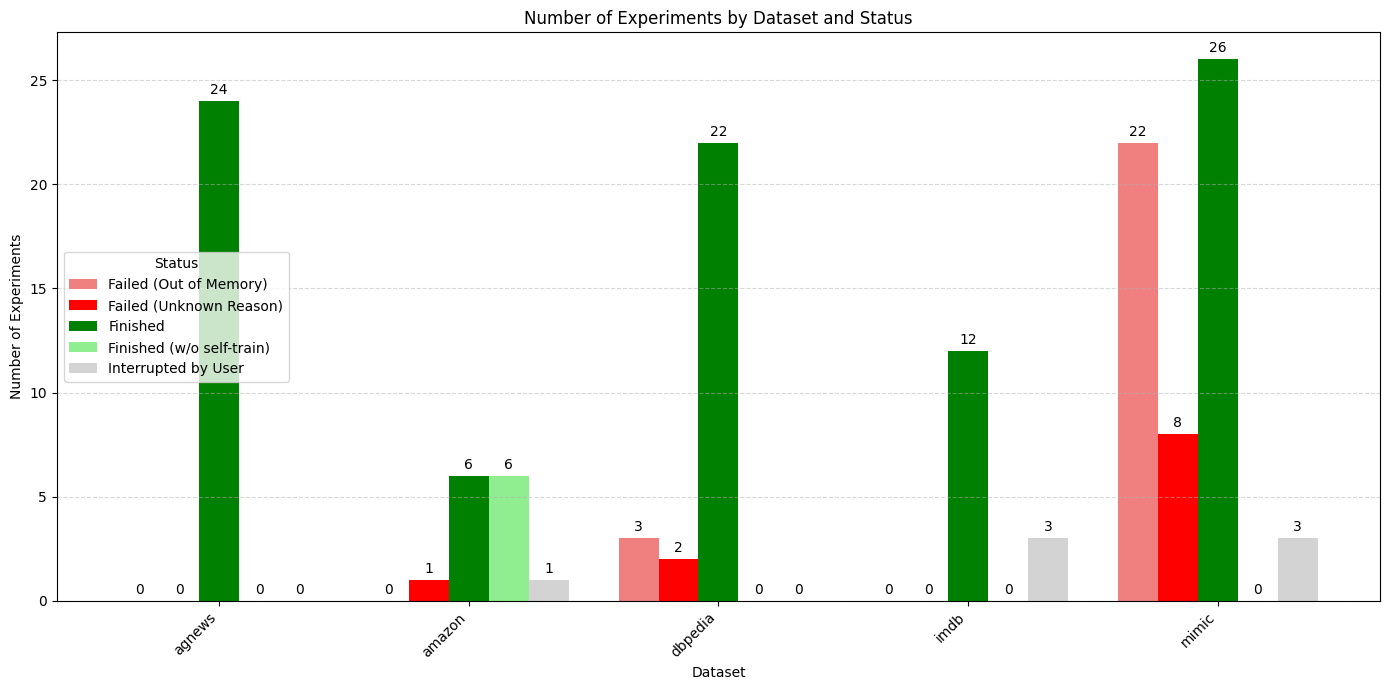

In [14]:
pivot = pivot.reset_index()
pivot = pivot.set_index('Dataset')
pivot = pivot.groupby('Dataset').sum()

# Drop unnecessary columns
#pivot = pivot.drop(columns=['Device Type'])

status_colors = {
    'Finished': 'green',
    'Finished (w/o self-train)': 'lightgreen',
    'Failed (Out of Memory)': 'lightcoral',
    'Failed (Unknown Reason)': 'red',
    'Interrupted by User': 'lightgray'
}

# Plot
ax = pivot.plot(
    kind='bar',
    figsize=(14, 7),
    color=[status_colors.get(col) for col in pivot.columns],  # Map the colors
    width=0.8
)

for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3)

plt.title('Number of Experiments by Dataset and Status')
plt.xlabel('Dataset')
plt.ylabel('Number of Experiments')
plt.legend(title='Status')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### 1.1.1 Analysis
---

Overall, the majority of experiments were completed successfully.

Nevertheless, as anticipated, the larger datasets (Amazon, DBPedia, and MIMIC) exhibited a **higher incidence of experiment failures**, primarily due to **hardware limitations** (specifically, CUDA Out of Memory errors) as well as unidentified causes.

To address these issues, **failed experiments were re-executed** using an upgraded hardware configuration, replacing the RTX 4090 GPU with an Nvidia H100 80GB GPU.

In cases where this modification proved insufficient — particularly for the DBPedia dataset — experiments were subsequently conducted on the CPU, utilizing a system with expanded RAM capacity.

## 1.2 Total Number GPU/CPU Hours Used for Experiments

The experiments took a considerable amount of time to complete. In this section, we breakdown the number of GPU and CPU hours used.

In [15]:
runtime_hours = df['Runtime (seconds)'] / 3600
gpu_mask = df['GPU Name'].notna() & df['GPU Name'].str.strip().ne('') & df['Device Type'].eq('CUDA')
gpu_hours = runtime_hours[gpu_mask].sum()
cpu_hours = runtime_hours[~gpu_mask].sum()

print(f"Total GPU hours: {gpu_hours:,.1f} (~{round(gpu_hours // 1)}h {round(gpu_hours*60 % 60)} min)")
print(f"Total CPU hours: {cpu_hours:,.1f} (~{round(cpu_hours // 1)}h {round(cpu_hours*60 % 60)} min)")

Total GPU hours: 444.3 (~444h 18 min)
Total CPU hours: 26.8 (~26h 45 min)


In [16]:
# Calculate runtime in hours
df['Runtime (hours)'] = df['Runtime (seconds)'] / 3600

# Create column to classify as GPU or CPU
df['Device Category'] = 'CPU'
df.loc[gpu_mask, 'Device Category'] = 'GPU'

# Group by Dataset and Device Category and sum Runtime (hours)
runtime_by_dataset_device = df.groupby(['Dataset', 'Device Category'])['Runtime (hours)'].sum().reset_index()
pivot_table = runtime_by_dataset_device.pivot(index='Dataset', columns='Device Category', values='Runtime (hours)').fillna(0)

def format_hours_minutes(hours):
    total_minutes = int(round(hours * 60))
    h, m = divmod(total_minutes, 60)
    return f"{h}h {m}min"

pretty_pivot_table = pivot_table.copy()

for col in pretty_pivot_table.columns:
    pretty_pivot_table[col] = pretty_pivot_table[col].apply(format_hours_minutes)

print("Total Runtime (hours and minutes) per Dataset and Device Type")
pretty_pivot_table

Total Runtime (hours and minutes) per Dataset and Device Type


Device Category,CPU,GPU
Dataset,,
agnews,0h 0min,11h 38min
amazon,0h 0min,121h 12min
dbpedia,9h 55min,145h 56min
imdb,0h 0min,3h 58min
mimic,16h 51min,161h 35min


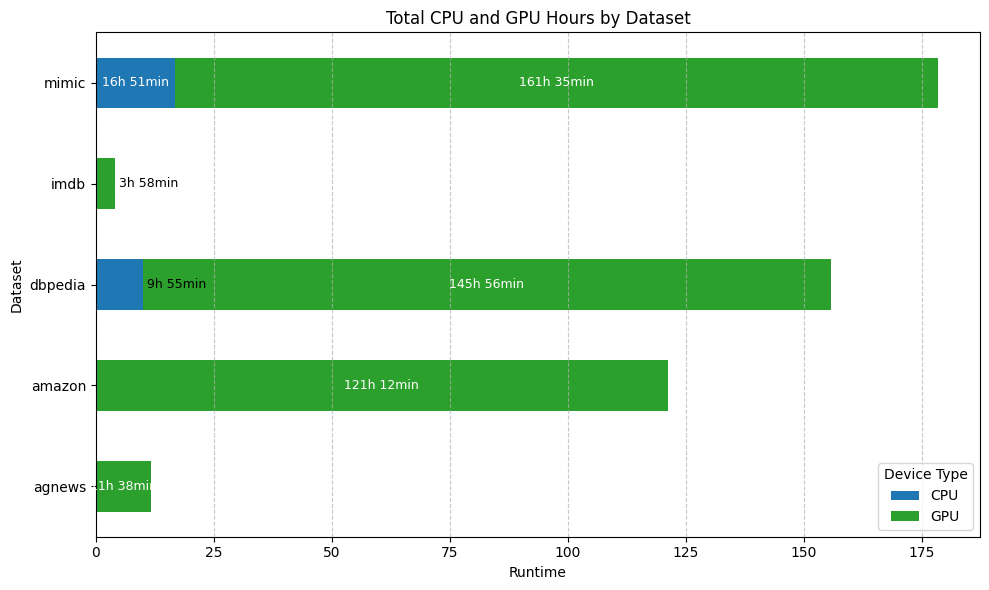

In [17]:
colors = {
    'CPU': '#1f77b4',  # Blue
    'GPU': '#2ca02c',  # Green
}

ax = pivot_table.plot(
    kind='barh', 
    stacked=True, 
    figsize=(10, 6),
    color=[colors.get(device, '#333333') for device in pivot_table.columns]
)

plt.title('Total CPU and GPU Hours by Dataset')
plt.xlabel('Runtime')
plt.ylabel('Dataset')
plt.legend(title='Device Type')
plt.grid(axis='x', linestyle='--', alpha=0.7)

for container in ax.containers:
    for bar in container:
        width = bar.get_width()
        if width > 0:
            total_minutes = int(round(width * 60))
            hours = total_minutes // 60
            minutes = total_minutes % 60
            label = f"{hours}h {minutes}min"
            
            if width < 10:
                ax.text(
                    bar.get_x() + width + 1,
                    bar.get_y() + bar.get_height() / 2,
                    label,
                    ha='left', va='center',
                    fontsize=9, color='black'
                )
            else:
                ax.text(
                    bar.get_x() + width / 2,
                    bar.get_y() + bar.get_height() / 2,
                    label,
                    ha='center', va='center',
                    fontsize=9, color='white'
                )

plt.tight_layout()
plt.show()

In [22]:
hw_cols = [
    "Device Type",
    "CPU Cores",
    "CPU Logical Cores",
    "GPU Name",
    "GPU Memory (GB)",
    "System RAM (GB)",
]

# Get only experiments that finished (experiments that skipped self-training did not register the HW configuration for some unknown reason!)
hw_df = df[df["Status"].str.contains("Finished", na=False)].copy()

# Get each distinct hardware configuration and how many runs used it
hardware_configs = (
    hw_df.groupby(hw_cols)
      .size()
      .reset_index(name="Finished Runs (with self-training)")
      .sort_values(hw_cols)
      .reset_index(drop=True)
)

hardware_configs

,Device Type,CPU Cores,CPU Logical Cores,GPU Name,GPU Memory (GB),System RAM (GB),Finished Runs (with self-training)
0,CPU,32.0,64.0,NVIDIA GeForce RTX 4090,24.0,503.7,2
1,CUDA,24.0,32.0,NVIDIA GeForce RTX 4090,24.0,125.6,56
2,CUDA,64.0,128.0,NVIDIA H100 80GB HBM3,79.6,503.4,1
3,CUDA,128.0,255.0,NVIDIA GeForce RTX 4090,24.0,2003.8,25
4,CUDA,192.0,192.0,NVIDIA H100 80GB HBM3,79.6,2267.5,6


### 1.2.1 Analysis

The reproduction effort required a substantial amount of computational resources, totaling **over 444 hours of GPU usage** and **more than 26 hours of CPU computation (exclusively, since CPU time was also used for the other experiments)**.

A significant portion of these resources was consumed by experiments involving the larger datasets, namely **MIMIC**, **DBPedia**, and **Amazon**. As previously discussed, due to the **insufficient GPU VRAM** for certain experiments, particularly those involving the MIMIC and DBPedia datasets, some runs were executed on a **CPU with 32 cores/64 threads** and **over 500 GB of system RAM** to overcome memory constraints.

Regarding hardware configurations, a total of six distinct systems were employed throughout the experiments, categorized as follows:

#### GPU-Based Training:
1. **Nvidia RTX 4090** (24 GB VRAM), CPU with **24 cores/32 threads**, **125 GB RAM**.
2. **Nvidia RTX 4090** (24 GB VRAM), CPU with **64 cores/128 threads**, **503 GB RAM**.
3. **Nvidia RTX 4090** (24 GB VRAM), CPU with **128 cores/255 threads**, **2 TB RAM** (approximate total system memory).
4. **Nvidia H100** (80 GB VRAM), CPU with **64 cores/128 threads**, **503 GB RAM**.
5. **Nvidia H100** (80 GB VRAM), CPU with **192 cores/192 threads**, **2.2 TB RAM** (approximate total system memory).

#### CPU-Based Training:
1. **CPU with 32 cores/64 threads** and **503 GB RAM** (the GPU available on this system was not utilized for these experiments).

# 1.3 Number of Training Epochs and Average Runtime per Epoch

In [24]:
# Get only experiments that finished (with or without self-train)
df_epochs = df[df["Status"].str.contains("Finished", na=False)].copy()

# Label model was always trained with 100 epochs (config file for each dataset)
LABEL_MODEL_EPOCHS = 100

# Add 1 to the end‑model epoch count because logging starts at 0
df_epochs["EM Epochs Corr"] = df_epochs["EM Epochs"].fillna(0) + 1

# Self‑trained end‑model epochs may be NaN (eg: Amazon dataset for majority voting); treat NaN as 0
df_epochs["ST Epochs"] = df_epochs["ST Epochs"].fillna(0)

# Calculate total epochs for a run = label‑model + corrected end‑model + self‑trained end‑model
# Due to the nature of the KeyClass model we don´t have runtime information separately for each model.
df_epochs["Total Epochs"] = LABEL_MODEL_EPOCHS + df_epochs["EM Epochs Corr"] + df_epochs["ST Epochs"]

# Calculate average runtime (seconds) per epoch
df_epochs["Avg Runtime per Epoch (s)"] = df_epochs["Runtime (seconds)"] / df_epochs["Total Epochs"]

summary_epochs = (
    df_epochs.groupby("Dataset")
      .agg(
          Total_Epochs_Min=("Total Epochs", "min"),
          Total_Epochs_Max=("Total Epochs", "max"),
          Total_Epochs_Mean=("Total Epochs", "mean"),
          Total_Avg_Runtime_Epoch_Sec=("Avg Runtime per Epoch (s)", "mean"),
          End_Model_Epochs_Min=("EM Epochs Corr", "min"),
          End_Model_Epochs_Max=("EM Epochs Corr", "max"),
          End_Model_Epochs_Mean=("EM Epochs Corr", "mean"),
          Self_Train_Epochs_Min=("ST Epochs", "min"),
          Self_Train_Epochs_Max=("ST Epochs", "max"),
          Self_Train_Epochs_Mean=("ST Epochs", "mean"),
      )
      .reset_index()
)

summary_epochs

,Dataset,Total_Epochs_Min,Total_Epochs_Max,Total_Epochs_Mean,Total_Avg_Runtime_Epoch_Sec,End_Model_Epochs_Min,End_Model_Epochs_Max,End_Model_Epochs_Mean,Self_Train_Epochs_Min,Self_Train_Epochs_Max,Self_Train_Epochs_Mean
0,agnews,118.0,419.0,216.875000,8.862428,9.0,20.0,16.916667,9.0,299.0,99.958333
1,amazon,120.0,257.0,144.833333,348.552223,10.0,20.0,17.250000,0.0,137.0,27.583333
2,dbpedia,107.0,1519.0,552.818182,55.415279,6.0,20.0,16.272727,1.0,1399.0,436.545455
3,imdb,113.0,134.0,128.166667,9.185909,9.0,20.0,16.166667,4.0,20.0,12.000000
4,mimic,217.0,217.0,217.000000,103.098901,20.0,20.0,20.000000,97.0,97.0,97.000000


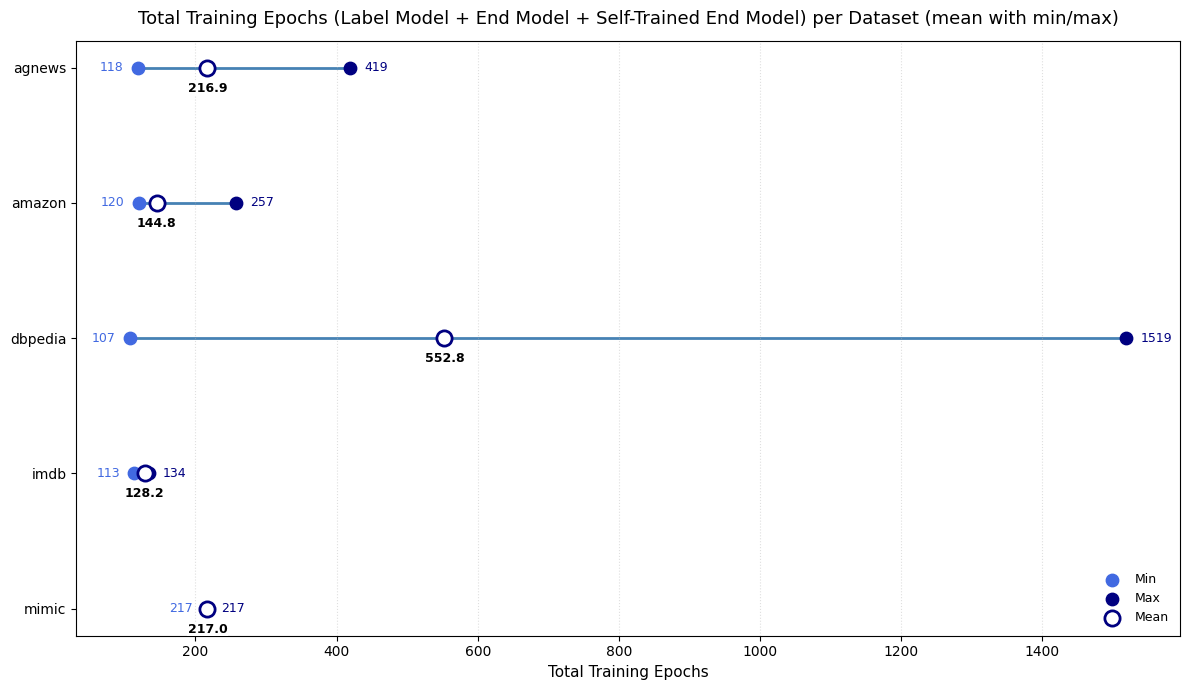

In [25]:
fig, ax = plt.subplots(figsize=(12, 7))  

y_pos = range(len(summary_epochs))

ax.hlines(
    y=y_pos,
    xmin=summary_epochs['Total_Epochs_Min'],
    xmax=summary_epochs['Total_Epochs_Max'],
    color='steelblue',
    linewidth=2,
    zorder=1,
)

ax.scatter(
    summary_epochs['Total_Epochs_Min'], y_pos,
    marker='o', s=80, color='royalblue', label='Min', zorder=2
)
ax.scatter(
    summary_epochs['Total_Epochs_Max'], y_pos,
    marker='o', s=80, color='navy', label='Max', zorder=2
)
ax.scatter(
    summary_epochs['Total_Epochs_Mean'], y_pos,
    marker='o', s=120, facecolors='white', edgecolors='navy',
    linewidth=2, label='Mean', zorder=3
)

# Labels
for y, (mn, mean, mx) in enumerate(
        zip(summary_epochs['Total_Epochs_Min'],
            summary_epochs['Total_Epochs_Mean'],
            summary_epochs['Total_Epochs_Max'])):

    ax.text(
        mn - 20, y, f"{mn:.0f}",
        va='center', ha='right', fontsize=9, color='royalblue',
        bbox=dict(facecolor='white', edgecolor='none', pad=0.5)
    )

    ax.text(
        mean, y + 0.20, f"{mean:.1f}",
        va='bottom', ha='center', fontsize=9, weight='bold',
        bbox=dict(facecolor='white', edgecolor='none', pad=0.5)
    )

    ax.text(
        mx + 20, y, f"{mx:.0f}",
        va='center', ha='left', fontsize=9, color='navy',
        bbox=dict(facecolor='white', edgecolor='none', pad=0.5)
    )

ax.set_yticks(y_pos)
ax.set_yticklabels(summary_epochs['Dataset'])
ax.set_xlabel("Total Training Epochs", fontsize=11)
ax.set_title("Total Training Epochs (Label Model + End Model + Self-Trained End Model) per Dataset (mean with min/max)", fontsize=13, pad=12)

pad = 0.05 * summary_epochs['Total_Epochs_Max'].max()
ax.set_xlim(
    left=summary_epochs['Total_Epochs_Min'].min() - pad,
    right=summary_epochs['Total_Epochs_Max'].max() + pad
)

ax.grid(axis='x', linestyle=':', alpha=0.4, zorder=0)
ax.legend(frameon=False, fontsize=9, loc='lower right')
ax.invert_yaxis()      # largest dataset on top

plt.tight_layout()
plt.show()

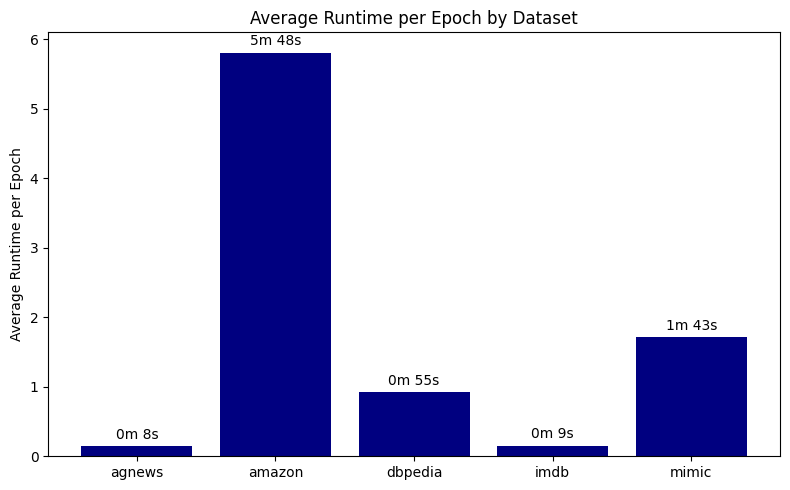

In [26]:
fig_rt, ax_rt = plt.subplots(figsize=(8, 5))

vals_sec = summary_epochs["Total_Avg_Runtime_Epoch_Sec"]
x = summary_epochs["Dataset"]

bars_rt = ax_rt.bar(x, vals_sec / 60, color="navy")

ax_rt.set_ylabel("Average Runtime per Epoch")
ax_rt.set_title("Average Runtime per Epoch by Dataset")

labels = [f"{int(v//60)}m {int(v%60)}s" for v in vals_sec]
ax_rt.bar_label(bars_rt, labels=labels, padding=3)

plt.tight_layout()
plt.show()

### 1.3.1 Analysis

- **Mean Runtime per Epoch:** The Amazon dataset recorded the greatest average runtime per training epoch, at **5 min 48 s**. The MIMIC experiments followed with **1 min 43 s** per epoch, whereas the AGNews and IMDb datasets exhibited substantially lower averages of **8 s** and **9 s**, respectively.  

- **Total Number of Epochs:** DBPedia presented the highest mean aggregate number of training epochs — considering the label model, end-model, and self-trained end-model phases — at **552.8** epochs, with the longest individual run encompassing **1,399** epochs.

# 2. Benchmark Datasets Reproducibity Results (AGNews, DBPedia, IMDb, Amazon)

Here we analyze our results using the default paper settings for the 4 benchmark datasets.

As mentioned in my Project Proposal, the paper used the following parameters:
- **End-Model Learning Rate**: 0.001 (1e-3)
- **End-Model Batch Size**: 128
- **Labeling Functions**: 15 for DBPedia, 300 for AGNews, Amazon, IMDb.

**Observation**: Due to **hardware and time constraints**, experiments with the Amazon dataset were limited to the label model and end model when paired with **majority voting**. This is due to the fact that the initial tests indicated that training the self-trained model would take too long to complete for each experiment. In addition, since the KeyClass paper does **not** provide self-trained or end model (without self-train) accuracy values for majority voting, this restriction did not impact reproducibility efforts.

In [27]:
bench = ['agnews', 'dbpedia', 'imdb', 'amazon']
bench_df = df[df['Dataset'].str.lower().isin(bench)].copy()

mask_default = (
    (bench_df['Learning Rate'] == 1e-3) &
    (bench_df['Batch Size'] == 128) &
    ((bench_df['Status'] == 'Finished') | (bench_df['Status'] == 'Finished (w/o self-train)')) &
    (
        ((bench_df['Dataset'].str.lower() == 'dbpedia') & (bench_df['LFs'] == 15)) |
        ((bench_df['Dataset'].str.lower() != 'dbpedia') & (bench_df['LFs'] == 300))
    )
)
default_df = bench_df[mask_default].copy()
default_df

selected_columns = {
    'Dataset': 'Dataset',
    'Label Model': 'Label Model',
    'LM Accuracy/F1': 'LM Accuracy/F1',
    'EM Accuracy/F1': 'End Model (w/o. self train) Accuracy',
    'EM Accuracy/F1 STD': 'End Model (w/o. self train) Accuracy STD',
    'ST Accuracy/F1': 'Self-Trained Accuracy',
    'ST Accuracy/F1 STD': 'Self-Trained Accuracy STD',
}

display_df = default_df[list(selected_columns.keys())].rename(columns=selected_columns)

# Format into "accuracy ± std" string for each dataset
display_df['Label Model Accuracy'] = display_df.apply(
    lambda row: f"{row['LM Accuracy/F1']:.3f}", axis=1
)
display_df['End Model (w/o self train) Accuracy ± STD'] = display_df.apply(
    lambda row: f"{row['End Model (w/o. self train) Accuracy']:.3f} ± {row['End Model (w/o. self train) Accuracy STD']:.3f}", axis=1
)
display_df['Self-Trained End Model (KeyClass) Accuracy'] = display_df.apply(
    lambda row: f"{row['Self-Trained Accuracy']:.3f} ± {row['Self-Trained Accuracy STD']:.3f}", axis=1
)

display_df

,Dataset,Label Model,LM Accuracy/F1,End Model (w/o. self train) Accuracy,End Model (w/o. self train) Accuracy STD,Self-Trained Accuracy,Self-Trained Accuracy STD,Label Model Accuracy,End Model (w/o self train) Accuracy ± STD,Self-Trained End Model (KeyClass) Accuracy
0,agnews,Data Programming,0.730717,0.829167,0.004718,0.863889,0.003738,0.731,0.829 ± 0.005,0.864 ± 0.004
1,agnews,Majority Vote,0.693975,0.831758,0.004104,0.845158,0.003809,0.694,0.832 ± 0.004,0.845 ± 0.004
24,amazon,Data Programming,0.727128,0.857796,0.000544,0.917642,0.000427,0.727,0.858 ± 0.001,0.918 ± 0.000
25,amazon,Majority Vote,0.718850,0.858114,0.000565,NaN,NaN,0.719,0.858 ± 0.001,nan ± nan
53,dbpedia,Data Programming,0.638218,0.813582,0.001561,0.771908,0.001494,0.638,0.814 ± 0.002,0.772 ± 0.001
54,dbpedia,Majority Vote,0.629886,0.831770,0.001345,0.908552,0.001110,0.630,0.832 ± 0.001,0.909 ± 0.001
65,imdb,Data Programming,0.700160,0.843601,0.002166,0.884718,0.001914,0.700,0.844 ± 0.002,0.885 ± 0.002
66,imdb,Majority Vote,0.720440,0.835992,0.002151,0.920310,0.001704,0.720,0.836 ± 0.002,0.920 ± 0.002


In [28]:
# Table 6 numbers from the KeyClass paper (AGNews, DBPedia, IMDb, Amazon)
paper_table_6 = pd.DataFrame(
    {
        "Dataset": ["agnews", "agnews",
                    "dbpedia", "dbpedia",
                    "imdb", "imdb",
                    "amazon", "amazon"],
        "Label Model": ["Data Programming", "Majority Vote"] * 4,

        # Label-model accuracy (paper)
        "Paper LM Acc": [
            0.731, 0.694,        # AGNews
            0.638, 0.630,        # DBPedia
            0.699, 0.717,        # IMDb
            0.580, 0.652,        # Amazon
        ],

        # End model w/o self-training (KeyClass w/o ST)
        "Paper EM Acc": [
            0.841, None,
            0.823, None,
            0.836, None,
            0.832, None,
        ],
        "Paper EM Std": [
            0.004, None,
            0.002, None,
            0.0019, None,
            0.001, None,
        ],
        # Self-trained end model (KeyClass ours)
        "Paper ST Acc": [
            0.867, None,
            0.951, None,
            0.895, None,
            0.941, None,
        ],
        "Paper ST Std": [
            0.004, None,
            0.001, None,
            0.002, None,
            0.000, None,
        ],
    }
)

compare_df = (
    display_df.merge(paper_table_6, on=["Dataset", "Label Model"], how="left")
    .loc[
        :,
        [
            "Dataset", "Label Model",
            "LM Accuracy/F1",      "Paper LM Acc",
            "End Model (w/o. self train) Accuracy",   "Paper EM Acc",
            "End Model (w/o. self train) Accuracy STD", "Paper EM Std",
            "Self-Trained Accuracy", "Paper ST Acc",
            "Self-Trained Accuracy STD", "Paper ST Std"
        ]
    ]
)

# Calculate deltas
compare_df[f"Δ Label Model"] = (compare_df["LM Accuracy/F1"].round(3) - compare_df["Paper LM Acc"]).abs()
compare_df[f"Δ End Model"] = (compare_df["End Model (w/o. self train) Accuracy"].round(3) - compare_df["Paper EM Acc"]).abs()
compare_df[f"Δ Self-Trained Model"] = (compare_df["Self-Trained Accuracy"].round(3) - compare_df["Paper ST Acc"]).abs()

final_df = compare_df.copy()

# Format into "accuracy ± std" string for each dataset
final_df['Label Model Accuracy'] = final_df.apply(
    lambda row: f"{row['LM Accuracy/F1']:.3f}", axis=1
)
final_df['Label Model Accuracy (Paper)'] = final_df.apply(
    lambda row: f"{row['Paper LM Acc']:.3f}", axis=1
)
final_df['End Model (w/o self train) Accuracy ± STD'] = final_df.apply(
    lambda row: f"{row['End Model (w/o. self train) Accuracy']:.3f} ± {row['End Model (w/o. self train) Accuracy STD']:.3f}", axis=1
)
final_df['End Model (w/o self train) Accuracy ± STD (Paper)'] = final_df.apply(
    lambda row: "Not informed" if pd.isna(row['Paper EM Acc']) else f"{row['Paper EM Acc']:.3f} ± {row['Paper EM Std']:.3f}", axis=1
)
final_df['Self-Trained End Model (KeyClass) Accuracy ± STD'] = final_df.apply(
    lambda row: "Not calculated due to HW/time restrictions" if pd.isna(row['Self-Trained Accuracy']) else f"{row['Self-Trained Accuracy']:.3f} ± {row['Self-Trained Accuracy STD']:.3f}", axis=1
)
final_df['Self-Trained End Model (KeyClass) Accuracy ± STD (Paper)'] = final_df.apply(
    lambda row: "Not informed" if pd.isna(row['Paper ST Acc']) else f"{row['Paper ST Acc']:.3f} ± {row['Paper ST Std']:.3f}", axis=1
)

# Remove initial columns
final_df = final_df.drop(columns=['Paper LM Acc', 'Paper EM Acc', 'Paper EM Std', 'Paper ST Acc', 'Paper ST Std', 'LM Accuracy/F1', 
                                  'End Model (w/o. self train) Accuracy', 'End Model (w/o. self train) Accuracy STD', 
                                  'Self-Trained Accuracy', 'Self-Trained Accuracy STD'] )

# Reorder columns
columns_order = [
    'Dataset',
    'Label Model',
    'Label Model Accuracy',
    'Label Model Accuracy (Paper)',
    'Δ Label Model',
    'End Model (w/o self train) Accuracy ± STD',
    'End Model (w/o self train) Accuracy ± STD (Paper)',
    'Δ End Model',
    'Self-Trained End Model (KeyClass) Accuracy ± STD',
    'Self-Trained End Model (KeyClass) Accuracy ± STD (Paper)',
    'Δ Self-Trained Model'
]
final_df = final_df[columns_order]
final_df = final_df.fillna("Not Available")
final_df

,Dataset,Label Model,Label Model Accuracy,Label Model Accuracy (Paper),Δ Label Model,End Model (w/o self train) Accuracy ± STD,End Model (w/o self train) Accuracy ± STD (Paper),Δ End Model,Self-Trained End Model (KeyClass) Accuracy ± STD,Self-Trained End Model (KeyClass) Accuracy ± STD (Paper),Δ Self-Trained Model
0,agnews,Data Programming,0.731,0.731,0.000,0.829 ± 0.005,0.841 ± 0.004,0.012,0.864 ± 0.004,0.867 ± 0.004,0.003
1,agnews,Majority Vote,0.694,0.694,0.000,0.832 ± 0.004,Not informed,Not Available,0.845 ± 0.004,Not informed,Not Available
2,amazon,Data Programming,0.727,0.580,0.147,0.858 ± 0.001,0.832 ± 0.001,0.026,0.918 ± 0.000,0.941 ± 0.000,0.023
3,amazon,Majority Vote,0.719,0.652,0.067,0.858 ± 0.001,Not informed,Not Available,Not calculated due to HW/time restrictions,Not informed,Not Available
4,dbpedia,Data Programming,0.638,0.638,0.000,0.814 ± 0.002,0.823 ± 0.002,0.009,0.772 ± 0.001,0.951 ± 0.001,0.179
5,dbpedia,Majority Vote,0.630,0.630,0.000,0.832 ± 0.001,Not informed,Not Available,0.909 ± 0.001,Not informed,Not Available
6,imdb,Data Programming,0.700,0.699,0.001,0.844 ± 0.002,0.836 ± 0.002,0.008,0.885 ± 0.002,0.895 ± 0.002,0.01
7,imdb,Majority Vote,0.720,0.717,0.003,0.836 ± 0.002,Not informed,Not Available,0.920 ± 0.002,Not informed,Not Available


## 2.1 Analysis of Results

### Notes on Reported Results
---
**Tables 5 and 6 of the KeyClass paper report slightly different accuracy values for the four datasets**, without providing an explanation for the observed discrepancies. 

In the dataset above, the results from **Table 6** were used due to their higher level of detail. However, in the analysis below, accuracy values from **both** Table 5 and Table 6 are referenced where appropriate.

### AGNews
---
The self-trained end model utilizing data programming achieved an accuracy of **0.864 ± 0.004**. 

This value is marginally lower, yet very close to the reported accuracies in the paper: **0.869 ± 0.004** (Table 5) and **0.867 ± 0.004** (Table 6).

Regarding additional values presented in Table 6 of the paper:
- The end model (without self-training) achieved an accuracy of **0.829 ± 0.005**, **lower** than the paper's reported **0.841 ± 0.004**.
- The label model with data programming attained an accuracy of **0.731**, **identical** to the paper's reported result.
- The label model with majority voting reached an accuracy of **0.694**, also **identical** to the paper's reported result.

**Conclusion**: 
1. The reproduction was **successful within the margin of error** for the self-trained end model.
2. The end model (without self-training) exhibited **slightly inferior** performance relative to the paper's reported accuracy.
3. The accuracy results for the label model were **identical** to those reported in the paper for both data programming and majority voting.

### DBPedia
---
The self-trained end model utilizing **data programming** achieved an accuracy of **0.772 ± 0.001**.

This result is **substantially lower** than the paper's reported values of **0.940 ± 0.001** (Table 5) and **0.951 ± 0.001** (Table 6).

**Observations**:
- The model was trained using **15** labeling functions, **strictly adhering** to the hyperparameter values described in the KeyClass paper.
- However, the [`config_dbpedia.yml`](https://github.com/autonlab/KeyClass/blob/main/config_files/config_dbpedia.yml) file in the KeyClass GitHub repository specifies **37** labeling functions (`topk: 37`), which likely influenced the results.
- Supporting this hypothesis, experiments conducted with **30** labeling functions during ablation studies (refer to Topic 4) achieved a self-trained end model accuracy of **0.941 ± 0.001**, closely **matching** the paper's reported values in Table 5.

Regarding additional values presented in Table 6 of the paper:
- The end model (without self-training) achieved an accuracy of **0.814 ± 0.002**, **slightly lower** than the paper's reported **0.823 ± 0.002**.
- The end model trained using **majority voting** for the label model achieved **0.832 ± 0.001**, **surpassing** the paper's reported results.
- The label model with **data programming** achieved an accuracy of **0.638**, **identical** to the paper's result.
- The label model with **majority voting** achieved an accuracy of **0.630**, also **identical** to the paper's result.

**Conclusion**:
1. Reproduction achieved **lower** results for the self-trained end model, potentially due to differences in the number of labeling functions reported versus those actually used.
2. The end model (without self-training) exhibited **slightly lower** performance compared to the paper's results.
3. The label model accuracy was **identical** to the paper's for **both** data programming and majority voting.

### IMDb
---
The self-trained end model achieved an accuracy of **0.885 ± 0.002**.

This value is **slightly higher** than the paper's reported **0.871 ± 0.002** (Table 5) but **slightly lower** than **0.895 ± 0.002** (Table 6).

Regarding additional values presented in Table 6 of the paper:
- The end model (without self-training) achieved an accuracy of **0.844 ± 0.002**, **exceeding** the paper's reported **0.836 ± 0.0019**.
- Using **majority voting** as the label model, the end model achieved **0.836 ± 0.002**, **identical** to the reported accuracy.
- The label model with **data programming** achieved an accuracy of **0.700**, **slightly higher** than the paper’s **0.699**.
- The label model with **majority voting** achieved **0.720**, **marginally higher** than the reported **0.717**.

**Conclusion**:
1. Reproduction was **successful within the margin of error** when comparing to Table 5, and **slightly inferior** when comparing to Table 6.
2. The end model (without self-training) achieved **slightly superior** performance compared to the paper’s results, and **matched** exactly when using **majority voting**.
3. The label model achieved **slightly higher** accuracies than those reported, for **both** data programming and majority voting.

### Amazon
---
The self-trained end model achieved an accuracy of **0.918 ± 0.000**.

This result is **lower** than the reported values of **0.928 ± 0.000** (Table 5) and **0.941 ± 0.000** (Table 6).

Regarding additional values presented in Table 6 of the paper:
- The end model (without self-training) achieved an accuracy of **0.858 ± 0.001**, **surpassing** the paper’s reported **0.832 ± 0.001**.
- The label model with **data programming** achieved an accuracy of **0.727**, significantly **higher** than the reported **0.580**.
- The label model with **majority voting** achieved an accuracy of **0.719**, considerably **higher** than the reported **0.652**.

**Observations**:
- The higher performance of the label models likely contributed to the higher accuracies observed in the end model (without self-training). Nevertheless, the final self-trained end model accuracy remained **lower** than the paper's reported results.

**Conclusion**:
1. The accuracy of the self-trained end model was **slightly lower** compared to the paper's reported values from both Table 5 and Table 6.
2. The end model (without self-training) achieved **slightly superior** performance relative to the reported values.
3. The label model achieved **significantly higher** accuracy than the paper's reported results for **both** data programming and majority voting.

# 3. Ablation/Extension 1: Learning Rate and Batch Size Impact on Model Performance

In alignment with the objectives outlined in the Project Proposal, a series of experiments were conducted to evaluate the impact of reducing the learning rate to 0.0001 and employing smaller batch sizes (64 and 32) on the accuracy of the self-trained end model.

These settings were compared against the baseline configuration reported in the KeyClass paper, which utilized a learning rate of **0.001** and a batch size of **128**. All other configuration parameters were held constant to ensure a controlled comparison.

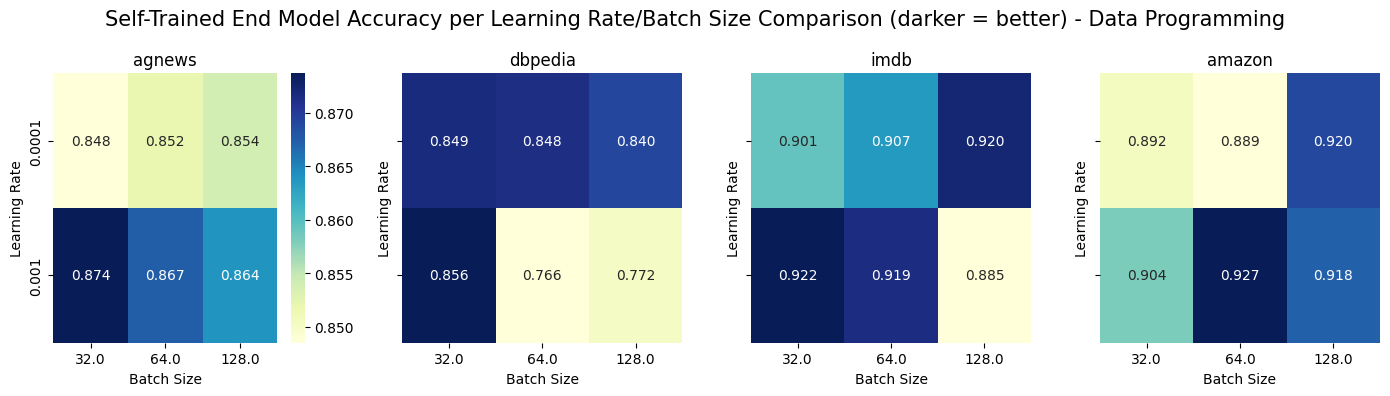

In [29]:
# Baseline hyperparameters used in the KeyClass paper
baseline_lr = 1e-3
baseline_bs = 128
baseline_lfs = { 'agnews': 300, 'dbpedia': 15, 'imdb': 300, 'amazon': 300 }

# Initialize plot data arrays
plot_data_dp = []
plot_data_mv = []

datasets = ['agnews', 'dbpedia', 'imdb', 'amazon']
df2 = df[df['Dataset'].str.lower().isin(datasets)].copy()

# Get only completed experiments (with or without self-train)
df3 = df2[df2['Status'].str.contains("Finished", na=False)].copy()

for dataset in datasets:
    lfs = baseline_lfs[dataset]
    
    dataset_results_dp = df3[
        (df3['Dataset'] == dataset) &
        (df3['LFs'] == lfs) &
        (df3['Label Model'] == 'Data Programming') &
        (df3['Learning Rate'].isin([1e-3, 1e-4])) &
        (df3['Batch Size'].isin([128, 64, 32])) 
    ]

    # Self-trained values were not calculated for Amazon dataset with majority voting due to HW constraints
    if dataset != 'amazon':
        dataset_results_mv = df3[
            (df3['Dataset'] == dataset) &
            (df3['LFs'] == lfs) &
            (df3['Label Model'] == 'Majority Vote') &
            (df3['Learning Rate'].isin([1e-3, 1e-4])) &
            (df3['Batch Size'].isin([128, 64, 32]))
        ]
    
    for _, row in dataset_results_dp.iterrows():
        plot_data_dp.append({
            'Dataset': dataset,
            'Label Model': row['Label Model'],
            'Learning Rate': row['Learning Rate'],
            'Batch Size': row['Batch Size'],
            'ST Accuracy/F1': row['ST Accuracy/F1'],
            'ST Accuracy/F1 STD': row.get('ST Accuracy/F1 STD', None)
        })

    # Self-trained values were not calculated for Amazon dataset with majority voting due to HW constraints
    if dataset != 'amazon':
        for _, row in dataset_results_mv.iterrows():
            plot_data_mv.append({
                'Dataset': dataset,
                'Label Model': row['Label Model'],
                'Learning Rate': row['Learning Rate'],
                'Batch Size': row['Batch Size'],
                'ST Accuracy/F1': row['ST Accuracy/F1'],
                'ST Accuracy/F1 STD': row.get('ST Accuracy/F1 STD', None)
            })

df_plot_dp = pd.DataFrame(plot_data_dp)
df_plot_mv = pd.DataFrame(plot_data_mv)

pivot = (
    df_plot_dp
      .pivot_table(index='Learning Rate', columns='Batch Size', values='ST Accuracy/F1', aggfunc='first')    
      .loc[[1e-4, 1e-3]]                                    
)

fig, axes = plt.subplots(1, len(df_plot_dp['Dataset'].unique()), figsize=(14,4), sharey=True)

for i, (ax, (dataset, df_dset)) in enumerate(zip(axes, df_plot_dp.groupby('Dataset', sort=False))):
    sns.heatmap(
        df_dset.pivot_table(index='Learning Rate', columns='Batch Size', values='ST Accuracy/F1'),
        annot=True, fmt=".3f", cmap="YlGnBu", ax=ax, cbar=i==0
    )
    ax.set_title(dataset)
    ax.set_xlabel("Batch Size")
    ax.set_ylabel("Learning Rate")

fig.suptitle("Self-Trained End Model Accuracy per Learning Rate/Batch Size Comparison (darker = better) - Data Programming", fontsize=15)
plt.tight_layout()
plt.show()

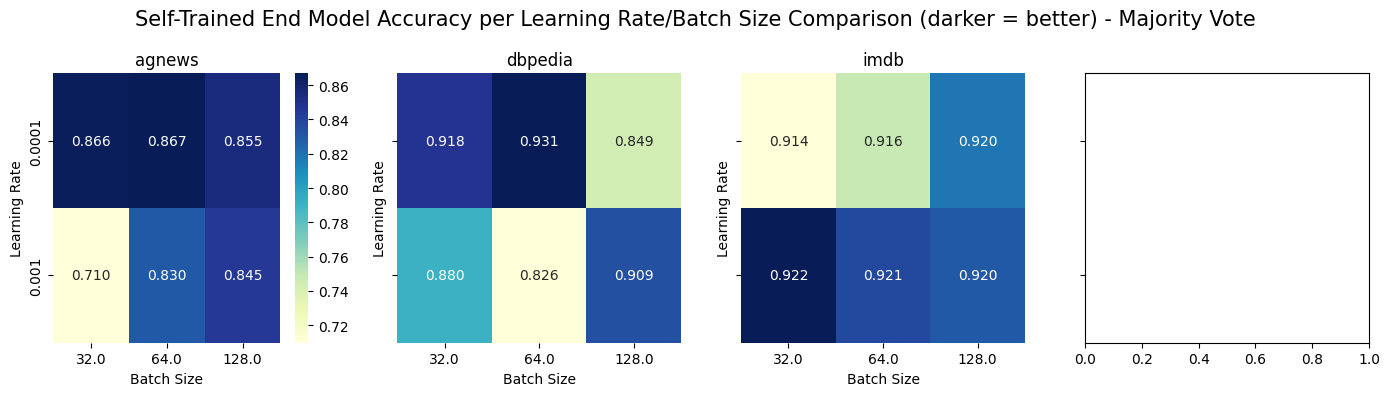

In [30]:
pivot = (
    df_plot_mv
      .pivot_table(index='Learning Rate', columns='Batch Size', values='ST Accuracy/F1', aggfunc='first')     
      .loc[[1e-4, 1e-3]]                                        
)

fig, axes = plt.subplots(1, len(df_plot_dp['Dataset'].unique()), figsize=(14,4), sharey=True)

for i, (ax, (dataset, df_dset)) in enumerate(zip(axes, df_plot_mv.groupby('Dataset', sort=False))):
    sns.heatmap(
        df_dset.pivot_table(index='Learning Rate', columns='Batch Size', values='ST Accuracy/F1'),
        annot=True, fmt=".3f", cmap="YlGnBu", ax=ax, cbar=i==0
    )
    ax.set_title(dataset)
    ax.set_xlabel("Batch Size")
    ax.set_ylabel("Learning Rate")

fig.suptitle("Self-Trained End Model Accuracy per Learning Rate/Batch Size Comparison (darker = better) - Majority Vote", fontsize=15)
plt.tight_layout()
plt.show()

## 3.1 Analysis of Results

### AGNews
---

The best accuracy achieved for the self-trained model was **0.874**, obtained using the paper's default learning rate of **0.001**, a batch size of **32** and **data programming**. This result **surpasses** the paper's reported accuracy of **0.869 ± 0.004** (Table 5) and **0.867 ± 0.004** (Table 6).

**Data Programming**: 
- For batch sizes of 128, 64, and 32, the accuracy achieved with the **default learning rate of 0.001** consistently **exceeded** that obtained with a learning rate of 0.0001.
- Thus, reducing the learning rate did **not** yield improved accuracy in this context.

**Majority Voting**: 
- The best result (**0.867**) was achieved with a learning rate of **0.0001** and a batch size of **64**. However, it remained **inferior** to the best result obtained with data programming.

### DBPedia
---

For data programming, which is the label model utilized in the paper, the best self-trained model accuracy was **0.856**, achieved with the default learning rate of **0.001** and a batch size of **32**. This performance remains **inferior** to the paper’s reported accuracies of **0.940 ± 0.001** (Table 5) and **0.951 ± 0.001** (Table 6).

As previously noted, the models were trained with only **15** labeling functions, corresponding to the hyperparameter configuration described in the KeyClass paper. Possible differences in the number of labeling functions used by the authors might explain the difference in performance.

**Data Programming**: 
- For batch sizes of 128 and 64, accuracy results with the default learning rate of 0.001 were **lower** than those obtained with a reduced learning rate of 0.0001.
- Overall, employing a smaller learning rate and reducing the batch size contributed to **improved** accuracy.
- Nevertheless, the best accuracy was still achieved using the **default** learning rate.

**Majority Voting**: 
- The highest accuracy (**0.931**) was obtained with a learning rate of **0.0001** and a batch size of **64**. This result **surpassed** the best accuracy achieved with **data programming** (**0.856**) and approached the paper’s reported results.
- Furthermore, all accuracy outcomes using **majority voting** were **superior** to those obtained with data programming across **all** learning rate and batch size combinations.

### IMDb 
---

The best self-trained model accuracy, **0.922**, was achieved using the default learning rate of **0.001**, a batch size of **32**, and **data programming**, thereby **surpassing** the paper’s reported accuracies of **0.871 ± 0.002** (Table 5) and **0.895 ± 0.002** (Table 6).

**Data Programming**:
- For batch sizes of 64 and 32, the **default** learning rate of 0.001 resulted in **higher** accuracy than a learning rate of 0.0001.
- A smaller learning rate **only** produced superior results when using the default batch size of 128.
- Additionally, when maintaining the default learning rate, reducing the batch size **improved** the self-trained model’s accuracy.

**Majority Voting**:
- The highest accuracy (**0.922**) was obtained with a learning rate of **0.0001** and a batch size of **32**, **matching** the best result obtained with data programming.
- Moreover, all accuracy results achieved using majority voting were **equal to or exceeded** those obtained with data programming across **all** learning rate and batch size combinations.

### Amazon
---

The best self-trained model accuracy, **0.927**, was achieved using the default learning rate of **0.001**, a batch size of **64**, and **data programming**. This result falls **within the margin of error** of the paper’s reported accuracy of **0.928 ± 0.002** (Table 5), although it remains **lower** than the accuracy reported in Table 6 (**0.941 ± 0.000**).

**Data Programming**:
- For batch sizes of **64 and 32**, the accuracy achieved with the **default** learning rate of 0.001 was **superior** to that obtained with a learning rate of 0.0001.
- A **smaller** learning rate produced better accuracy **only** when using the default batch size of **128**.
- In most experiments, **reducing** the batch size did **not** result in improved accuracy.

**Majority Voting**: 
- As previously mentioned, training of the self-trained model with majority voting was **not** performed for the Amazon dataset **due to hardware and time constraints**.

# 4. Ablation/Extension 2: Increasing the Number of Labeling Functions for the DBPedia Dataset

According to the KeyClass paper, **only 15 labeling functions** were employed for the DBPedia dataset due to **computational and storage constraints**.

Consistent with the Project Proposal, additional experiments were conducted to evaluate the impact of **increasing the number of labeling functions** on model accuracy for the DBPedia dataset.

Due to time constraints, the analysis focused on experimental runs using a learning rate of **0.001** (the paper's default), a batch size of **128** (default), and varying numbers of labeling functions: **15, 30, 50, 100, 250, and 300**.

In [31]:
df4 = df[df['Dataset'].str.lower().isin(bench)].copy()

# Filter the experiments with the default KeyClass onfiguration for each dataset
mask_default = (
    (df4['Learning Rate'] == 1e-3) &
    (df4['Batch Size'] == 128) &
    (df4['Status'] == 'Finished') &
    (df4['Dataset'].str.lower() == 'dbpedia')
)
df_dbpedia = df4[mask_default].copy()

# Rename columns
selected_columns = {
    'Dataset': 'Dataset',
    'Label Model': 'Label Model',
    'LFs': 'Labeling Functions',
    'LM Accuracy/F1': 'LM Accuracy/F1',
    'EM Accuracy/F1': 'End Model (w/o. self train) Accuracy',
    'EM Accuracy/F1 STD': 'End Model (w/o. self train) Accuracy STD',
    'ST Accuracy/F1': 'Self-Trained Accuracy',
    'ST Accuracy/F1 STD': 'Self-Trained Accuracy STD',
}
df_dbpedia_2 = df_dbpedia[list(selected_columns.keys())].rename(columns=selected_columns)

# Format into "accuracy ± std" string for each dataset
df_dbpedia_2['Label Model Accuracy'] = df_dbpedia_2.apply(
    lambda row: f"{row['LM Accuracy/F1']:.3f}", axis=1
)
df_dbpedia_2['End Model (w/o self train) Accuracy ± STD'] = df_dbpedia_2.apply(
    lambda row: f"{row['End Model (w/o. self train) Accuracy']:.3f} ± {row['End Model (w/o. self train) Accuracy STD']:.3f}", axis=1
)
df_dbpedia_2['Self-Trained End Model (KeyClass) Accuracy'] = df_dbpedia_2.apply(
    lambda row: f"{row['Self-Trained Accuracy']:.3f} ± {row['Self-Trained Accuracy STD']:.3f}", axis=1
)

# Drop unused columns
df_dbpedia_3 = df_dbpedia_2.drop(columns=['LM Accuracy/F1', 'End Model (w/o. self train) Accuracy', 'End Model (w/o. self train) Accuracy STD', 
                                  'Self-Trained Accuracy', 'Self-Trained Accuracy STD'] )

df_dbpedia_3

df_dbpedia_sorted = df_dbpedia_3.sort_values(
    by=['Self-Trained End Model (KeyClass) Accuracy', 'Labeling Functions'],
    ascending=[False, True]
)

df_dbpedia_sorted

,Dataset,Label Model,Labeling Functions,Label Model Accuracy,End Model (w/o self train) Accuracy ± STD,Self-Trained End Model (KeyClass) Accuracy
51,dbpedia,Data Programming,30.0,0.707,0.895 ± 0.001,0.941 ± 0.001
52,dbpedia,Majority Vote,30.0,0.694,0.870 ± 0.001,0.912 ± 0.001
54,dbpedia,Majority Vote,15.0,0.630,0.832 ± 0.001,0.909 ± 0.001
49,dbpedia,Data Programming,50.0,0.743,0.900 ± 0.001,0.908 ± 0.001
43,dbpedia,Data Programming,250.0,0.745,0.902 ± 0.001,0.907 ± 0.001
38,dbpedia,Data Programming,300.0,0.745,0.902 ± 0.001,0.907 ± 0.001
50,dbpedia,Majority Vote,50.0,0.735,0.878 ± 0.001,0.906 ± 0.001
48,dbpedia,Majority Vote,100.0,0.759,0.895 ± 0.001,0.898 ± 0.001
46,dbpedia,Data Programming,100.0,0.757,0.902 ± 0.001,0.894 ± 0.001
45,dbpedia,Majority Vote,250.0,0.757,0.884 ± 0.001,0.880 ± 0.001


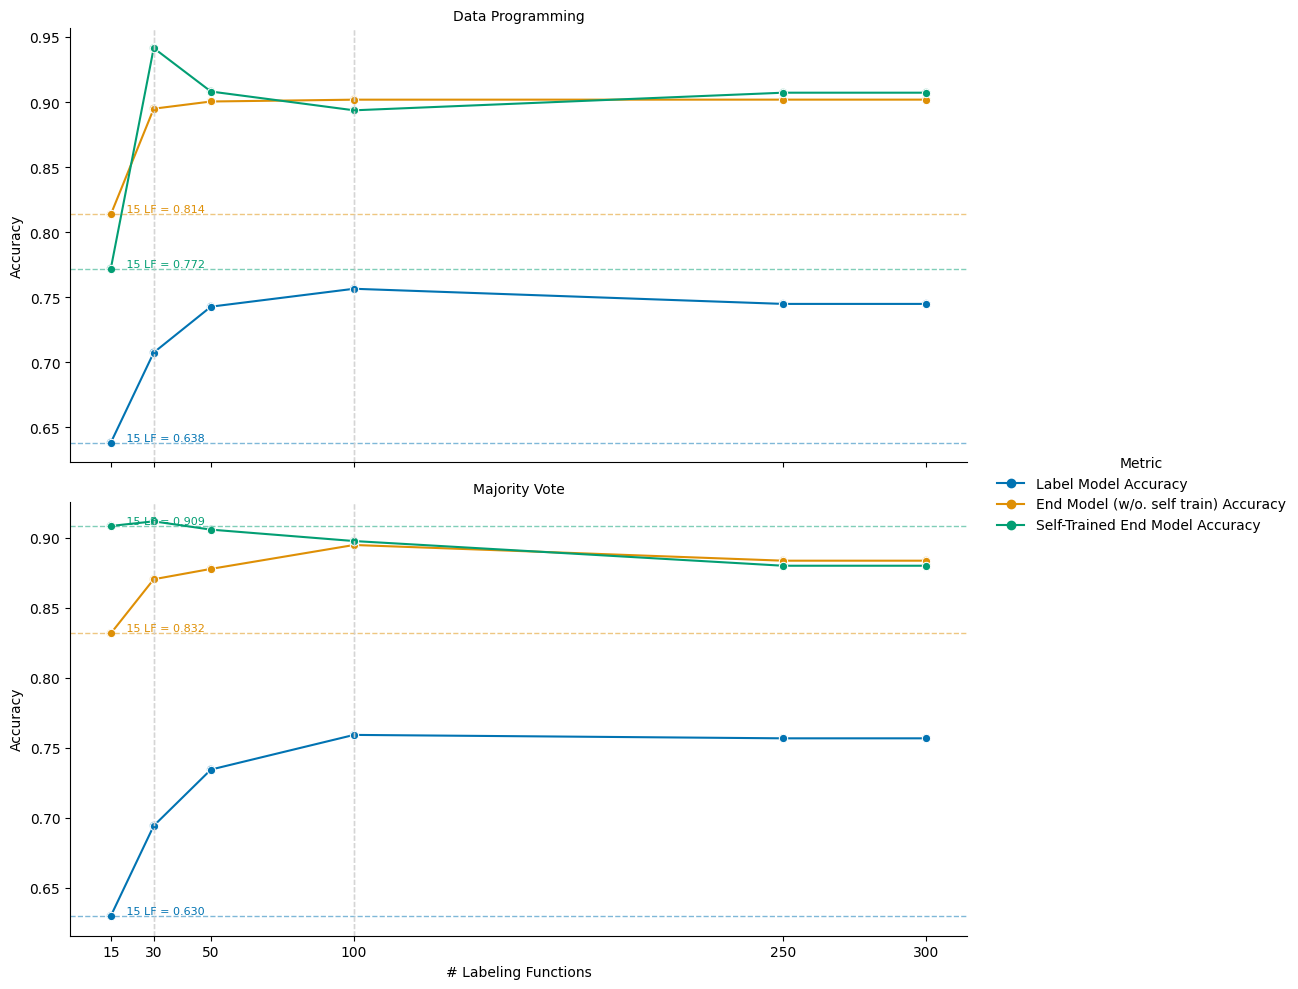

In [134]:
# Columns needed
cols = ["Label Model", "LFs", "LM Accuracy/F1", "EM Accuracy/F1", "ST Accuracy/F1"]
df5 = df_dbpedia[cols].copy()

# Rename Columns
selected_columns = {
    'Label Model': 'Label Model',
    'LFs': 'Labeling Functions',
    'LM Accuracy/F1': 'Label Model Accuracy',
    'EM Accuracy/F1': 'End Model (w/o. self train) Accuracy',
    'ST Accuracy/F1': 'Self-Trained End Model Accuracy',
}
df5 = df5[list(selected_columns.keys())].rename(columns=selected_columns)

# Cast Labeling Functions as int (instead of float)
df5["Labeling Functions"] = df5["Labeling Functions"].astype(int)

# Get baseline for 15 labeling functions
baseline = (
    df5[df5["Labeling Functions"] == 15]
    .set_index("Label Model")[[
        "Label Model Accuracy",
        "End Model (w/o. self train) Accuracy",
        "Self-Trained End Model Accuracy"
    ]]
)

# Compute absolute and relative lifts vs. baseline
for metric in [
    "Label Model Accuracy",
    "End Model (w/o. self train) Accuracy",
    "Self-Trained End Model Accuracy",
]:
    df5[f"{metric} Δ"] = (
        df5.apply(lambda r: r[metric] - baseline.loc[r["Label Model"], metric], axis=1)
    )
    df5[f"{metric} %Δ"] = (
        df5.apply(lambda r: 100 * r[f"{metric} Δ"] / baseline.loc[r["Label Model"], metric], axis=1)
    )

# Reshape to long form for plotting
long = (
    df5.melt(
        id_vars=["Label Model", "Labeling Functions"],
        value_vars=[
            "Label Model Accuracy",
            "End Model (w/o. self train) Accuracy",
            "Self-Trained End Model Accuracy",
        ],
        var_name="Metric",
        value_name="Accuracy",
    )
)

# Colours and ordering
palette = sns.color_palette("colorblind", n_colors=3)
metric_order = [
    "Label Model Accuracy",
    "End Model (w/o. self train) Accuracy",
    "Self-Trained End Model Accuracy",
]

# Plot accuracies for the 3 models
g = sns.relplot(
    data=long,
    x="Labeling Functions",
    y="Accuracy",
    hue="Metric",
    row="Label Model",
    kind="line",
    marker="o",
    palette=palette,
    hue_order=metric_order,
    facet_kws={"sharey": False},
    height=5, aspect=2
)

g.map_dataframe(sns.scatterplot, x="Labeling Functions", y="Accuracy", hue="Metric",
                palette=palette, legend=False)

# Add horizontal dashed baseline lines
for ax, (label_model, subdf) in zip(g.axes.flatten(), df.groupby("Label Model")):
    for m, col in enumerate(metric_order):
        y0 = baseline.loc[label_model, col]
        ax.set_xticks([15, 30, 50, 100, 250, 300])
        ax.axhline(y0, ls="--", lw=1, color=palette[m], alpha=.5)
        for xpos in [30, 100]:
            ax.axvline(
                x=xpos,
                linestyle="--",
                color="lightgray",
                alpha=0.6,
                linewidth=1
            )
        ax.text(
            x=df5["Labeling Functions"].min() - 3,
            y=y0,
            s=f"       15 LF = {y0:.3f}",
            va="bottom",
            ha="left",
            fontsize=8,
            color=palette[m],
        )

g.set_titles("{row_name}")               
g.set_axis_labels("# Labeling Functions", "Accuracy")
g.tight_layout()
plt.show()

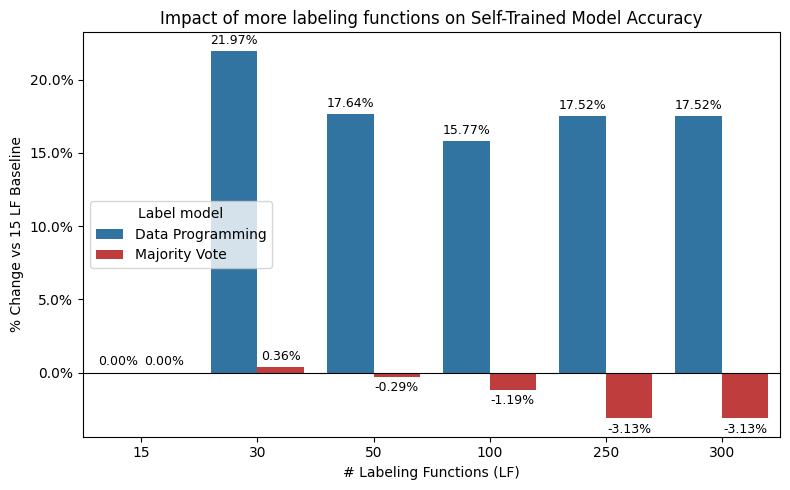

In [150]:
st = df5[df5["Metric"] == "Self-Trained End Model Accuracy"] if "Metric" in df5.columns else df5.copy()

custom_palette = {
    "Data Programming": "#1f77b4",  # Blue
    "Majority Vote": "#d62728"     # Red
}

plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=st,
    x="Labeling Functions",
    y="Self-Trained End Model Accuracy %Δ",
    hue="Label Model",
    palette=custom_palette
)

# Format y-axis as percentage
ax.yaxis.set_major_formatter(PercentFormatter())

# Add horizontal line at y=0
plt.axhline(0, color="k", lw=0.8)

# Axis labels and title
plt.ylabel("% Change vs 15 LF Baseline")
plt.xlabel("# Labeling Functions (LF)")
plt.title("Impact of more labeling functions on Self-Trained Model Accuracy")

# Add value labels on bars
for container in ax.containers:
    ax.bar_label(
        container,
        fmt='%.2f%%',
        padding=3,
        fontsize=9
    )

plt.legend(title="Label model")
plt.tight_layout()
plt.show()

In [62]:
# Relative gain compared to baseline table
gain_cols = [
    "Label Model", "Labeling Functions",
    "Label Model Accuracy %Δ",
    "End Model (w/o. self train) Accuracy %Δ",
    "Self-Trained End Model Accuracy %Δ"
]
display(
    df5[gain_cols]
      .sort_values(["Label Model", "Labeling Functions"])
      .style
      .hide(axis="index")
      .background_gradient(cmap="RdYlGn", vmin=-5, vmax=5)
)

Label Model,Labeling Functions,Label Model Accuracy %Δ,End Model (w/o. self train) Accuracy %Δ,Self-Trained End Model Accuracy %Δ
Data Programming,15,0.000000,0.000000,0.000000
Data Programming,30,10.851646,9.990938,21.965771
Data Programming,50,16.378756,10.671597,17.638905
Data Programming,100,18.533472,10.844044,15.769271
Data Programming,250,16.710315,10.847766,17.522588
Data Programming,300,16.710315,10.847766,17.522588
Majority Vote,15,0.000000,0.000000,0.000000
Majority Vote,30,10.229747,4.652556,0.361266
Majority Vote,50,16.608455,5.543169,-0.289645
Majority Vote,100,20.540291,7.596724,-1.186708


## 4.1 Analysis

- Moving from **15 to 30** labeling functions raises self-trained accuracy by +0.169 (**~ 21.97 %**), with gains in the accuracies of the label-model (~ +10.85 %) and end-model (~ +9.99 %).
- The best self-trained end model accuracy of **0.941 ± 0.001** was achieved with only **30** labeling functions. This result falls **within the margin of error** of the paper’s reported accuracy of **0.940 ± 0.001** (Table 5), although it remains **lower** than the accuracy reported in Table 6 (**0.951 ± 0.001**).
- Beyond 30 labeling functions, we see possibly **diminishing returns**, with self-trained accuracy oscillating around 0.900 to 0.940.
- Additional experiments should focus on testing the interval between **31 and 49 labeling functions** for the DBPedia dataset to see if results further increase the accuracy of the self-trained model. Unfortunately, due to time constraints we were unable to perform further testing.

# 5. MIMIC Dataset Reproducibility Results

**Table 3** in the KeyClass paper compares `KeyClass` and `FasTag (Venkataraman et al., 2020)` on the MIMIC-3 ICD-9 code assignment task, reporting aggregate Recall, Precision, and F1 scores. 

It is important to emphasize that the authors **did not provide the source code for the multi-label classification variant of KeyClass**. 

Consequently, I attempted to reconstruct the implementation based only on the available single-label source code and the methodological details outlined in the paper.

Beyond the absence of the multi-label source code, several critical details regarding the pipeline were **not provided**, significantly hindering the reproducibility efforts:

- **Pre-processing logic and detailed steps used to filter the relevant portions of each discharge note** were not disclosed;
- **Number of labeling functions (`topk`)** employed in the MIMIC configuration file was not specified. This parameter is fundamental to the model's performance. To address this gap, experiments were conducted with varying numbers of labeling functions: 30, 40, 50, 80, 100, 150, 200, 250, and 300. This led to several runs **failing due to hardware limitations**, necessitating the use of more powerful GPUs and, in some cases, CPUs. Nevertheless, certain experiments continued to fail even under these conditions;
- **Number of keyword descriptions utilized per target class** was not provided;
- Whether the number of labeling functions was allowed to vary between target classes (by default, KeyClass constrains this to the minimum number of available keywords available among all classes;
- **N-gram range** used for the MIMIC classification task was not specified. Although the paper mentions employing n-gram ranges between 1 and 3 depending on the dataset, it does not clarify which range was used for MIMIC. Accordingly, I performed training runs using n-gram ranges of (1,1) and (1,2). Due to hardware and time constraints, we were unable to experiment with (1,3).

Moreover, recognizing that many of the 19 top-level ICD-9 categories naturally share a number of common keywords, I conducted experiments under two different settings:
1. **Unfiltered** descriptions: Following the procedure described in the paper, with the top **30** keywords per class (an arbitrary constraint due to the lack of specification by the authors);
2. **Filtered** descriptions: Also selects the top **30** keywords after removing top keywords shared by 30% or more of the target classes, in an effort to enhance the performance of the label model.

## 5.1 Overall Recall, Precision, F1 Scores for Completed Runs

Results are ordered by descending (highest to lowest) F1 score of the self-trained end model.

In [151]:
# Get completed MIMIC runs
mimic_df = df[(df['Dataset'] == 'mimic') & df['Status'].str.contains("Finished", na=False)].copy()

# Rename columns
mimic_df2 = mimic_df.rename(columns={
    'LFs': 'Labeling Functions',
    'N-Gram Range': 'N-Gram Range',
    'ST Accuracy/F1': 'Self-Trained Model F1',
    'ST Accuracy/F1 STD': 'Self-Trained Model F1 STD',
    'ST Recall': 'Self-Trained Model Recall',
    'ST Recall STD': 'Self-Trained Model Recall STD',
    'ST Precision': 'Self-Trained Model Precision',
    'ST Precision STD': 'Self-Trained Model Precision STD',
    'Runtime Formatted': 'Runtime'
})

# Sort by highest F1 Score and least number of labeling functions
mimic_df2 = mimic_df2.sort_values(
    by=['Self-Trained Model F1', 'Labeling Functions'],  
    ascending=[False, True]  
)

# Generate display columns
mimic_df2['Self-Trained Model Recall ± STD'] = mimic_df2.apply(
    lambda row: f"{row['Self-Trained Model Recall']:.3f} ± {row['Self-Trained Model Recall STD']:.4f}", axis=1
)
mimic_df2['Self-Trained Model Precision ± STD'] = mimic_df2.apply(
    lambda row: f"{row['Self-Trained Model Precision']:.3f} ± {row['Self-Trained Model Precision STD']:.4f}", axis=1
)
mimic_df2['Self-Trained Model F1 ± STD'] = mimic_df2.apply(
    lambda row: f"{row['Self-Trained Model F1']:.3f} ± {row['Self-Trained Model F1 STD']:.4f}", axis=1
)

# Re‑order to show
cols_to_show = [
    'Class Descriptions', 'Labeling Functions', 'N-Gram Range',
    'Self-Trained Model Recall ± STD',     'Self-Trained Model Precision ± STD', 'Self-Trained Model F1 ± STD', 'Runtime'
]

mimic_df2[cols_to_show]

,Class Descriptions,Labeling Functions,N-Gram Range,Self-Trained Model Recall ± STD,Self-Trained Model Precision ± STD,Self-Trained Model F1 ± STD,Runtime
128,Filtered,40.0,"(1, 1)",0.131 ± 0.0013,0.543 ± 0.0041,0.201 ± 0.0018,5h 58m 45s
116,Unfiltered,80.0,"(1, 1)",0.126 ± 0.0014,0.602 ± 0.0041,0.199 ± 0.0018,6h 38m 24s
123,Filtered,50.0,"(1, 1)",0.126 ± 0.0012,0.559 ± 0.0045,0.196 ± 0.0018,6h 0m 21s
132,Filtered,30.0,"(1, 1)",0.124 ± 0.0015,0.516 ± 0.0048,0.190 ± 0.0020,5h 56m 7s
117,Filtered,80.0,"(1, 1)",0.120 ± 0.0012,0.563 ± 0.0046,0.189 ± 0.0017,6h 0m 12s
111,Filtered,100.0,"(1, 1)",0.120 ± 0.0012,0.563 ± 0.0046,0.189 ± 0.0017,6h 0m 10s
102,Filtered,150.0,"(1, 1)",0.120 ± 0.0012,0.563 ± 0.0046,0.189 ± 0.0017,6h 1m 14s
96,Filtered,200.0,"(1, 1)",0.120 ± 0.0012,0.563 ± 0.0046,0.189 ± 0.0017,5h 59m 51s
87,Filtered,250.0,"(1, 1)",0.120 ± 0.0012,0.563 ± 0.0046,0.189 ± 0.0017,6h 0m 13s
81,Filtered,300.0,"(1, 1)",0.120 ± 0.0012,0.563 ± 0.0046,0.189 ± 0.0017,6h 0m 25s


## 5.2 Best Results for Filtered and Unfiltered Class Descriptions

Let's get only the best F1 scores for **filtered** and **unfiltered** class descriptions.

In [152]:
# Get the best results for Filtered and Unfiltered (KeyClass default) class descriptions
best_per_class = mimic_df2.groupby('Class Descriptions').head(1)
best_per_class[cols_to_show]

,Class Descriptions,Labeling Functions,N-Gram Range,Self-Trained Model Recall ± STD,Self-Trained Model Precision ± STD,Self-Trained Model F1 ± STD,Runtime
128,Filtered,40.0,"(1, 1)",0.131 ± 0.0013,0.543 ± 0.0041,0.201 ± 0.0018,5h 58m 45s
116,Unfiltered,80.0,"(1, 1)",0.126 ± 0.0014,0.602 ± 0.0041,0.199 ± 0.0018,6h 38m 24s


## 5.3 Analysis

As evidenced by the results, our attempt to replicate the findings reported for the MIMIC-III dataset was only partially successful.

Our self-trained models achieved an F1 score of **0.201 ± 0.0018** (filtered descriptions) and ****0.199 ± 0.0018**** (unfiltered descriptions), substantially lower than the paper's results (Table 3) of ****0.6252 ± 0.0014****. 

| Class Descriptions | Labeling Functions | N-Gram Range | Self-Trained Model Recall ± STD | Self-Trained Model Precision ± STD | Self-Trained Model F1 ± STD | Runtime   |
|:-------------------|:-------------------|:-------------|:--------------------------------|:----------------------------------|:----------------------------|:----------|
| KeyClass (Paper)   | Not informed       | Not Informed | 0.896 ± 0.0009                  | 0.507 ± 0.0016                    | 0.6252 ± 0.0014             | Not informed          |
| Our Model (unfiltered class descriptions)         | 80                 | (1,1)        | 0.126 ± 0.0014                  | 0.602 ± 0.0041                    | 0.199 ± 0.0018              | 6h 38m 24s |
| Our Model (filtered class descriptions)           | 40                 | (1,1)        | 0.131 ± 0.0013                  | 0.543 ± 0.0041                    | 0.201 ± 0.0018              | 5h 58m 45s |

### Achievements

In addition to our attempt to adapt the source code for the MIMIC-III discharge notes classification task, we were able to reproduce the following steps of the methodology:

1. **Creation of Class Descriptions for 19 Top-Level ICD-9 Categories:**
Development of a script that, utilizing the official ICD-9 code descriptions, generates a list of top-level keywords for each classification target. The resulting class descriptions closely align with those presented in the original paper (Table 1) for target classes **Respiratory System** and **Genitourinary System**.

2. **Generation of the MIMIC Dataset for the Classification Task**:
By adapting FasTag’s MIMIC-III dataset preprocessing R script—with necessary corrections—we successfully created the dataset required for the classification experiments. This dataset was constructed with n-hot encoded vectors. However, due to the absence of detailed information regarding the filtering of the most relevant parts of each discharge note, we had to use the **unfiltered, full discharge notes**. This limitation likely contributed to discrepancies in our results relative to the original study.

### Potential Reasons for Discrepancies

Possible factors that contributed to the differences observed between our results and those reported in the KeyClass paper are related to the pre-processing pipeline, most notably how the discharge notes were filtered, and possible flaws in the attempt to adapt the original source code for multi-label classification, resulting in an underlying implementation that may be suboptimal.